In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

SPOTIFY_GREEN = "#1DB954"

In [2]:
metadata = pd.json_normalize(pd.read_json("../../dataset/metadata_genres.json")["results"])

<AxesSubplot: title={'center': 'Genres (total: 6065 songs)'}>

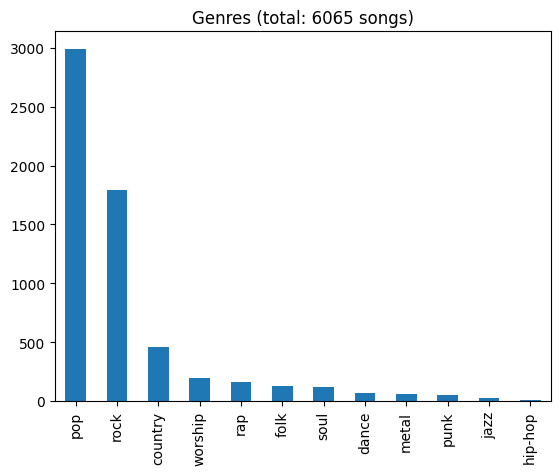

In [3]:
buckets = {
            "worship": ["worship", "christian", "gospel"],
            "folk": ["folk"],
            "dance": ["dance", "disco"],
            "metal": ["metal"],
            "jazz": ["jazz"],
            "country": ["country"],
            "rap": ["rap", "trap"],
            "punk": ["punk"],
            "soul": ["soul"],
            "hip-hop": ["hiphop", "hip-hop", "hip hop"],
            "rock": ["rock", "mellow gold", "grunge", "beatlesque"],
            "pop": ["pop", "new romantic", "adult standards", "new wave", "permanent wave", "urban contemporary"],
            }

def normalize_genre(genres):
    flattened_list = set([])
    for genre in genres:
        didBucket = False
        for bucket, keys in buckets.items():
            for k in keys:
                if k in genre:
                    flattened_list.add(bucket)
                    didBucket = True
                    break
            if didBucket: break
        if not didBucket:
            # flattened_list.add("other")
            pass
                
    return list(flattened_list)

metadata["new_genres"] = metadata["genres"].apply(lambda x: normalize_genre(x))
metadata = metadata[metadata["new_genres"].apply(lambda x: len(x) > 0)]

top_ten = pd.DataFrame(np.concatenate(metadata["new_genres"].tolist()).ravel().tolist())
top_ten_keys = [k for k, v in sorted({k[0]: c for k, c in top_ten.value_counts().items()}.items(), key=lambda x: -x[1])]

def get_top_genre(genres):
    for t in top_ten_keys:
        if t in genres:
            return t

metadata["top_genre"] = metadata["new_genres"].apply(lambda x: get_top_genre(x))
metadata["top_genre"].value_counts().plot.bar(title=f"Genres (total: {len(metadata)} songs)")

<AxesSubplot: title={'center': 'Popularity of Top Genres'}, xlabel='Top Genre', ylabel='Average Popularity %'>

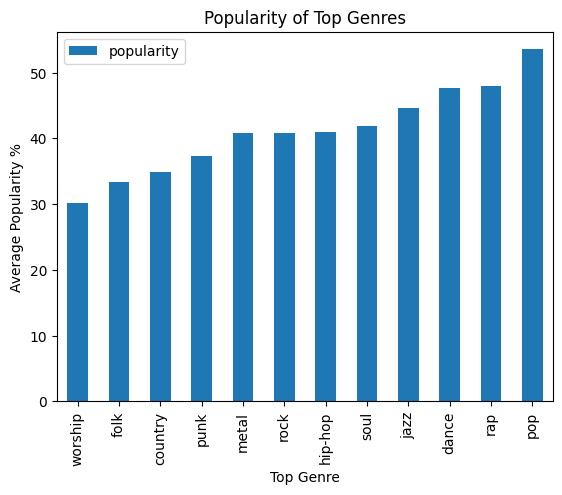

In [4]:
popularity = metadata.groupby(by="top_genre").mean(numeric_only=True).sort_values(by="popularity")
popularity.plot.bar(xlabel="Top Genre", ylabel="Average Popularity %", title="Popularity of Top Genres")

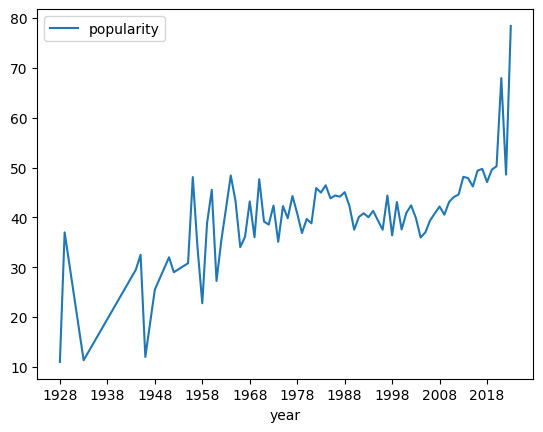

In [5]:
metadata["year"] = pd.to_datetime(metadata["release_date"]).dt.year
metadata.groupby(by="year").mean(numeric_only=True).plot()
ticks = plt.xticks(ticks=range(metadata["year"].min(), metadata["year"].max(), 10))

In [12]:
def clean_hyperlink(df):
    rm = '=hyperlink("C:\\Users\\rpilo\\Downloads\\orpheus\\dataset\\output\\coref_CoreNLP_minified_corpus\\coref\\'
    df["song_path"] = df["Document"].apply(lambda p: p[len(rm):-2])
    

In [13]:
svo_coref_gender = pd.read_csv("../../dataset/output/SVO_coref_CoreNLP_minified_corpus/gender/NLP_SVO_CoreNLP_gender_Dir_coref.csv")
svo_coref_gender = svo_coref_gender.dropna()
clean_hyperlink(svo_coref_gender)
svo_coref_gender

Subject (S) S Gender  Verb (V) Object (O) O Gender  Sentence ID  \
986         Jesus     MALE       cry      Jesus     MALE            3   
2021       George     MALE     calls     George     MALE            2   
2749           He     MALE      save         He     MALE            9   
3213        Romeo     MALE     loved     Juliet   FEMALE           15   
3655          him     MALE       say        him     MALE           20   
...           ...      ...       ...        ...      ...          ...   
59856          He     MALE       is         God     MALE           24   
59858          He     MALE       is         God     MALE           26   
59860          He     MALE       is         God     MALE           28   
59862          He     MALE       is         God     MALE           30   
59892         him     MALE  smile at        him     MALE            3   

                                                Sentence  Document ID  \
986    When Jesus lived here on this earth Jesus knew...          139   
2021   Everyone is wearing big smiles Everyone all tr...          262   
2749   He was trying to save He 's job He was, He was...          334   
3213                                 Romeo loved Juliet.          374   
3655           him 'll say him just wants to be friends.          385   
...                                                  ...          ...   
59856                                         He is God.         6446   
59858                                         He is God.         6446   
59860                                         He is God.         6446   
59862                                         He is God.         6446   
59892  To watch him die and smile At him dismay, him ...         6448   

                                                Document  \
986    =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
2021   =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
2749   =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
3213   =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
3655   =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
...                                                  ...   
59856  =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
59858  =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
59860  =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
59862  =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   
59892  =hyperlink("C:\Users\rpilo\Downloads\orpheus\d...   

                                               song_path  
986    Alison_Krauss_Everybody_Wants_To_Go_To_Heaven.txt  
2021               Arrogant_Worms_The_Christmas_Song.txt  
2749                             Beautiful_South_36D.txt  
3213                              Bette_Midler_Fever.txt  
3655                        Bette_Midler_Married_Men.txt  
...                                                  ...  
59856                           Zao_Growing_In_Grace.txt  
59858                           Zao_Growing_In_Grace.txt  
59860                           Zao_Growing_In_Grace.txt  
59862                           Zao_Growing_In_Grace.txt  
59892                        Zao_Times_Of_Separation.txt  

[124 rows x 10 columns]

In [ ]:
df = svo_coref_gender.merge(metadata, left_on="song_path", right_on="song_path")

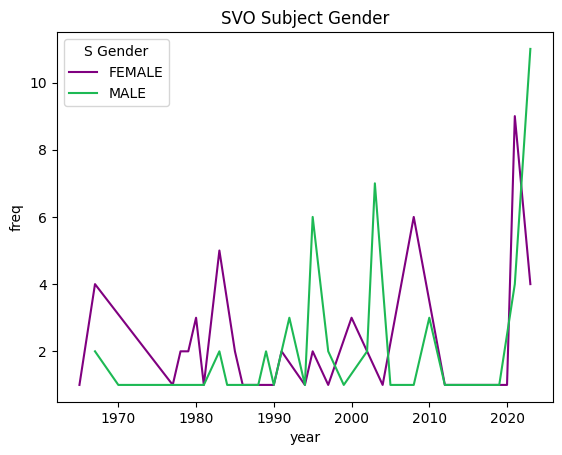

In [96]:
v = list(df.groupby(by="year")["S Gender"].value_counts().items())

k = [_keys[1] for _keys, _y in v]
x = [_keys[0] for _keys, _y in v]
y = [_y for _keys, _y in v]
rows = [[_k, _x, _y] for _k, _x, _y in zip(k, x, y)]
rows

gender_year = pd.DataFrame(rows, columns=["S Gender", "year", "freq"])
g = sns.lineplot(
    data=gender_year,
    x = "year",
    y = "freq",
    hue="S Gender",
    palette={"MALE": SPOTIFY_GREEN, "FEMALE": "purple"})

_ = g.set_title("SVO Subject Gender")

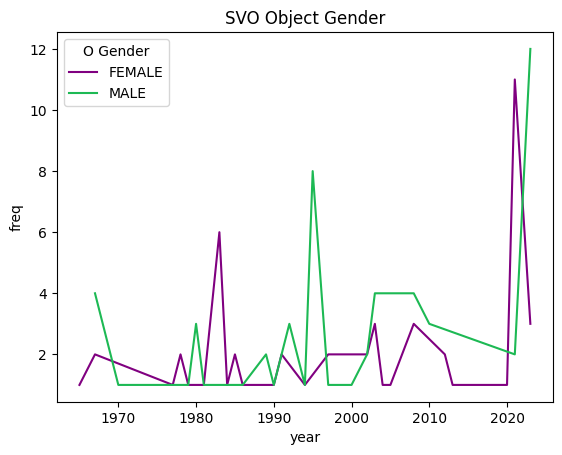

In [124]:
v2 = list(df.groupby(by="year")["O Gender"].value_counts().items())

k2 = [_keys[1] for _keys, _y in v2]
x2 = [_keys[0] for _keys, _y in v2]
y2 = [_y for _keys, _y in v2]
rows2 = [[_k, _x, _y] for _k, _x, _y in zip(k2, x2, y2)]

gender_year2 = pd.DataFrame(rows2, columns=["O Gender", "year", "freq"])
g2 = sns.lineplot(
    data=gender_year2,
    x = "year",
    y = "freq",
    hue="O Gender",
    palette={"MALE": SPOTIFY_GREEN, "FEMALE": "purple"})
_ = g2.set_title("SVO Object Gender")

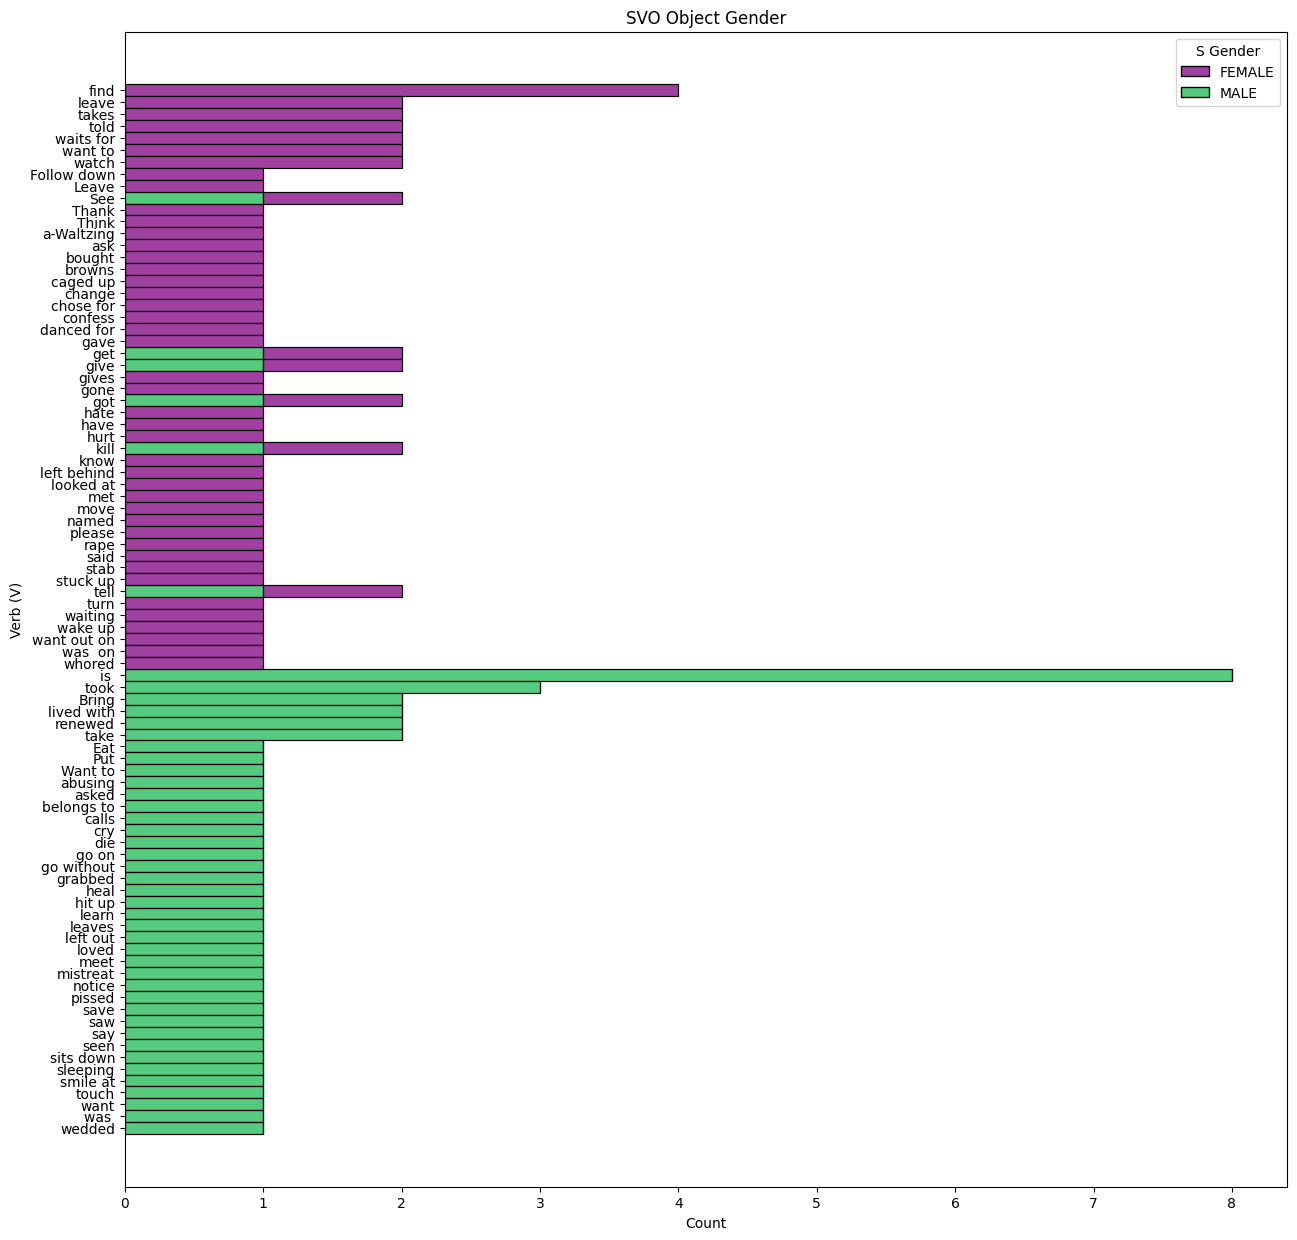

In [132]:
v3 = list(df.groupby(by="S Gender")["Verb (V)"].value_counts().items())
k3 = [_keys[0] for _keys, _y in v3]
x3 = [_keys[1] for _keys, _y in v3]
y3 = [_y for _keys, _y in v3]
rows3 = [[_k, _x, _y] for _k, _x, _y in zip(k3, x3, y3) if _y > 0]

fig, ax = plt.subplots(figsize=(15, 15))
gender_verbs = pd.DataFrame(rows3, columns=["S Gender", "Verb (V)", "freq"])
g3 = sns.histplot(
    ax=ax,
    data=gender_verbs,
    y = "Verb (V)",
    weights = "freq",
    multiple="stack",
    hue="S Gender",
    palette={"MALE": SPOTIFY_GREEN, "FEMALE": "purple"})

_ = g3.set_title("SVO Object Gender")

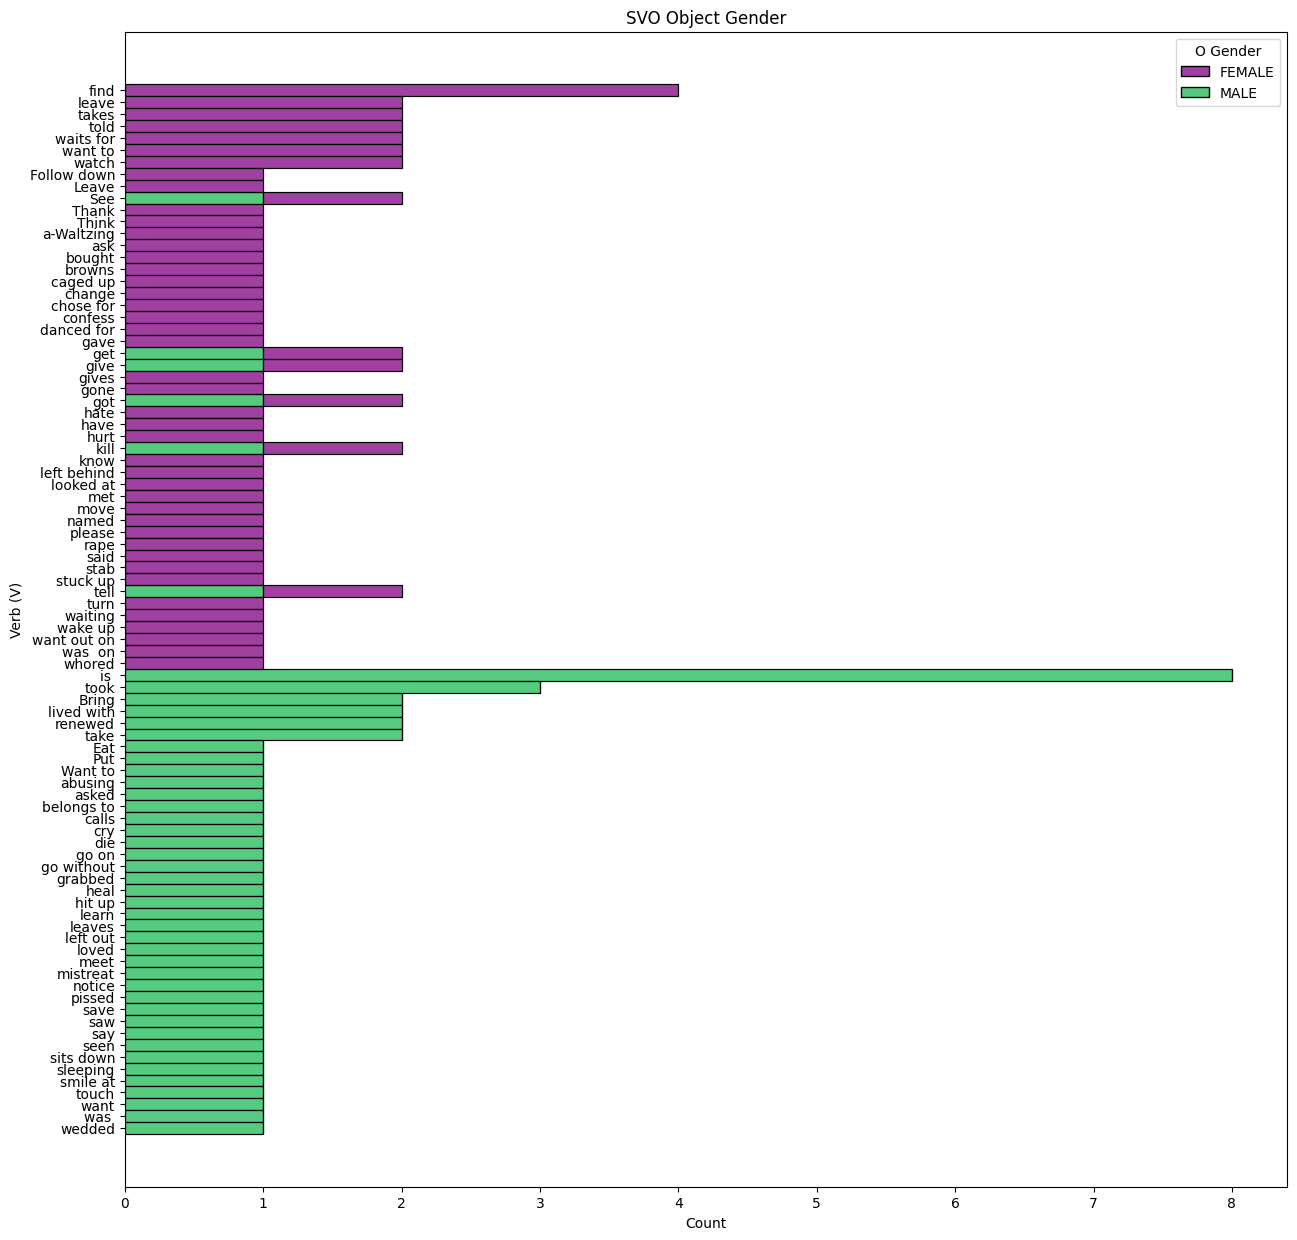

In [131]:
v4 = list(df.groupby(by="O Gender")["Verb (V)"].value_counts().items())
k4 = [_keys[0] for _keys, _y in v4]
x4 = [_keys[1] for _keys, _y in v4]
y4 = [_y for _keys, _y in v4]
rows4 = [[_k, _x, _y] for _k, _x, _y in zip(k4, x4, y4) if _y > 0]

fig, ax = plt.subplots(figsize=(15, 15))
gender_verbs2 = pd.DataFrame(rows3, columns=["O Gender", "Verb (V)", "freq"])
g4 = sns.histplot(
    ax=ax,
    data=gender_verbs2,
    y = "Verb (V)",
    weights = "freq",
    multiple="stack",
    hue="O Gender",
    palette={"MALE": SPOTIFY_GREEN, "FEMALE": "purple"})

_ = g4.set_title("SVO Object Gender")